## **Setup**

In [ ]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# from fastai.basics import *
# from fastai.callback.all import *
# from fastai.vision.all import *
# from fastai.vision.widgets import *
# from fastai.vision import *
# from fastai.callback.cutmix import *

In [ ]:
# !pip install utils
# from utils import *

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
!pip install utils
from utils import *

In [ ]:
from fastai.vision.all import *

In [ ]:
import os
import shutil
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
from zipfile import ZipFile
from tempfile import TemporaryDirectory
from PIL import Image

import cv2
from google.colab.patches import cv2_imshow
import imutils
from scipy.optimize import minimize_scalar

from sklearn.metrics import f1_score, accuracy_score

# plot options
# plt.rcParams.update({'font.size': 11})
plt.style.use('fivethirtyeight')

In [ ]:
# Set and test path to competition data files
competition_path = 'My Drive/AI For Good - AI Blitz 3/Sudoku/Data/'
model_path = 'My Drive/AI For Good - AI Blitz 3/Sudoku/Models/'
filename = 'train.tar.gz'
assert(os.path.exists(f'{mount_path}/{competition_path}/train.tar.gz'))
print('Drive mounted correctly and data accessible')

Drive mounted correctly and data accessible


# Functions

In [ ]:
def sqdif(bingray,sq,ang):
  rsq=imutils.resize(imutils.rotate_bound(sq,ang),width=imsz,height=imsz)

  return np.sum(np.abs(bingray-rsq))

In [ ]:
def derotate(img):
  sq=np.ones(img.shape)*255

  # binarize by blurring then using Otsu's method
  # blur=cv2.GaussianBlur(gray,(1,1),0)
  _,bingray = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  rotang=minimize_scalar(lambda ang: sqdif(bingray,sq,ang),
                         bounds=[-45,45], method='Bounded').x

  if rotang<0:
    triang=np.tan(np.pi/4+rotang*np.pi/180)
    act_x=imsz/2*(1+triang)
    act_y=imsz/2*(1-triang)

    pts1 = np.float32([[0,act_y],[act_x,0],[imsz-act_x,imsz],[imsz,imsz-act_y]])

  else:
    triang=np.tan(np.pi/4-rotang*np.pi/180)
    act_x=imsz/2*(1-triang)
    act_y=imsz/2*(1+triang)

    pts1 = np.float32([[act_x,0],[imsz,imsz-act_y],[0,act_y],[imsz-act_x,imsz]])

  pts2 = np.float32([[0,0],[imsz,0],[0,imsz],[imsz,imsz]])
  M = cv2.getPerspectiveTransform(pts1,pts2)
  
  return cv2.warpPerspective(img,M,(imsz,imsz))

In [ ]:
# SUDOKU SOLVING ALGORITHM BY PETER NORVIG https://norvig.com/sudoku.html
# slightly modified by Benjamin P Isaacoff on 8/29/20
# original code (pre-modification by BPI) taken from https://github.com/Adityaojas/sudoku-solver/blob/master/norvig.py

def cross(A, B):
  "Cross product of elements in A and elements in B."
  return [a+b for a in A for b in B]
    
digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits
squares  = cross(rows, cols)
unitlist = ([cross(rows, c) for c in cols] +
        [cross(r, cols) for r in rows] +
        [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
units = dict((s, [u for u in unitlist if s in u]) 
         for s in squares)
peers = dict((s, set(sum(units[s],[]))-set([s]))
         for s in squares)


def test():
  "A set of unit tests."
  assert len(squares) == 81
  assert len(unitlist) == 27
  assert np.all(len(units[s]) == 3 for s in squares)
  assert np.all(len(peers[s]) == 20 for s in squares)
  assert units['C2'] == [['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2'],
                          ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'],
                          ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']]
  assert peers['C2'] == set(['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2',
                              'C1', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
                              'A1', 'A3', 'B1', 'B3'])
  print('All tests pass.')


def parse_grid(grid):
  """Convert grid to a dict of possible values, {square: digits}, or
  return False if a contradiction is detected."""
  ## To start, every square can be any digit; then assign values from the grid.
  values = dict([(s, digits) for s in squares])
  for s,d in list(grid_values(grid).items()):
      if d in digits and not assign(values, s, d):
          return False ## (Fail if we can't assign d to square s.)
  return values

def grid_values(grid):
  "Convert grid into a dict of {square: char} with '0' or '.' for empties."
  chars = [c for c in grid if c in digits or c in '0.']
  assert len(chars) == 81
  return dict(list(zip(squares, chars)))


def assign(values, s, d):
  """Eliminate all the other values (except d) from values[s] and propagate.
  Return values, except return False if a contradiction is detected."""
  other_values = values[s].replace(d, '')
  if np.all([eliminate(values, s, d2) for d2 in other_values]):
      return values
  else:
      return False

def eliminate(values, s, d):
  """Eliminate d from values[s]; propagate when values or places <= 2.
  Return values, except return False if a contradiction is detected."""
  if d not in values[s]:
      return values ## Already eliminated
  values[s] = values[s].replace(d,'')
  ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
  if len(values[s]) == 0:
    return False ## Contradiction: removed last value
  elif len(values[s]) == 1:
      d2 = values[s]
      if not np.all([eliminate(values, s2, d2) for s2 in peers[s]]):
          return False
  ## (2) If a unit u is reduced to only one place for a value d, then put it there.
  for u in units[s]:
    dplaces = [s for s in u if d in values[s]]
    if len(dplaces) == 0:
        return False ## Contradiction: no place for this value
    elif len(dplaces) == 1:
        # d can only be in one place in unit; assign it there
          if not assign(values, dplaces[0], d):
              return False
  return values

def sudoku_display(instr):
  for rowind in range(9):
    rowstr=[]
    for colind in range(9):
      rowstr.append(str(instr[9*rowind+colind]))
      if colind==2 or colind==5: rowstr.append('|')
    print(' '.join(rowstr))

    if rowind==2 or rowind==5:
      print('---------------------')
  print(' ')
    
def solve(grid):
  return search(parse_grid(grid))


def search(values):
  "Using depth-first search and propagation, try all possible values."
  if values is False:
      return False ## Failed earlier
  if np.all([len(values[s]) == 1 for s in squares]): 
      return values ## Solved!
  ## Chose the unfilled square s with the fewest possibilities
  n,s = min([(len(values[s]), s) for s in squares if len(values[s]) > 1])
  return some([search(assign(values.copy(), s, d)) for d in values[s]])

def some(seq):
  "Return some element of seq that is true."
  for e in seq:
      if e: return e
  return False


#solve("400000805030000000000700000020000060000080400000010000000603070500200000104000000")
#solve([0, 0, 0, 0, 0, 0, 8, 1, 8, 0, 0, 0, 2, 3, 0, 0, 0, 6, 0, 0, 5, 7, 0, 0, 1, 0, 7, 0, 9, 6, 0, 0, 0, 0, 0, 9, 0, 7, 0, 4, 0, 1, 0, 0, 0, 0, 0, 8, 1, 0, 4, 0, 6, 0, 0, 2, 4, 0, 0, 8, 0, 0, 4, 5, 0, 0, 9, 3, 5, 0, 0, 0, 0, 0, 0])

#parse_grid("4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......")

In [ ]:
def extractNsolve(img,plot_res=False):
  curgrid=[]
    
  for rowind in range(9):
    for colind in range(9):
      subimg=img[(rowind*int(imsz/9)):((rowind+1)*int(imsz/9)),
                 (colind*int(imsz/9)):((colind+1)*int(imsz/9))]
      clfimg=learn.predict(np.stack((subimg,)*3, axis=-1))[0]
      
      if clfimg=='blank':
        curgrid.append('.')
      else:
        curgrid.append(clfimg)

      if plot_res:
        print(clfimg)
        cv2_imshow(subimg)
      
  curgrid=''.join(curgrid)

  try:
    solved=solve(curgrid)
    solved_grid=''.join(solved.values())
    
    return curgrid, solved_grid
  except:
    # print('Solving failed')
    return curgrid, 'sudontku'

  

# Load the digit training images and train the learner

In [ ]:
# train_dir='/content/train_dir/'

# # All_Data is the home directory for the images, from which training and validation splits will be taken
# if not os.path.exists(train_dir):
#   os.mkdir(train_dir)

#   with ZipFile(f'{mount_path}/{competition_path}/GeneratedNumImgs.zip', 'r') as zip_ref:
#         zip_ref.extractall(train_dir)

In [ ]:
# dls = ImageDataLoaders.from_folder(train_dir+'GeneratedNumImgs/',valid_pct=0.001,
#                                    batch_tfms=aug_transforms(do_flip=False, flip_vert=False, max_rotate=30.0,
#                                                           min_zoom=.8, max_zoom=1.2, max_lighting=0.2, max_warp=0.2))

In [ ]:
# learn = cnn_learner(dls, resnet34, pretrained=False) #, metrics=[accuracy],cbs=[ShowGraphCallback()])
# learn.fit_one_cycle(n_epoch=5,lr_max=1e-2)

# Load Sudoku Data

In [ ]:
home_dir='/content/All_Data/'
# this can take a bit (maybe 30s)
# All_Data is the home directory for the images, from which training and validation splits will be taken
if not os.path.exists(home_dir):
  os.mkdir(home_dir)
  shutil.unpack_archive(f'{mount_path}/{competition_path}/train.tar.gz',home_dir)  

In [ ]:
imgs=glob.glob('/content/All_Data/train/images/*.png')

In [ ]:
solutions=pd.read_csv('/content/All_Data/train/labels.csv')

In [ ]:
learn=load_learner(f'{mount_path}{model_path}200906_1150_fullgennums.pkl')

# Solution loop

In [ ]:
labeldict={0:'1',1:'2',2:'3',3:'4',4:'5',5:'6',6:'7',7:'8',8:'9',9:'.'}

tmpdir='imgs4solv/'
# this can take a bit (maybe 30s)
# All_Data is the home directory for the images, from which training and validation splits will be taken
if not os.path.exists(f'{home_dir}{tmpdir}'):
  os.mkdir(f'{home_dir}{tmpdir}')

In [ ]:
def extractNsolve(impath):

  imid=os.path.basename(impath)[:-4]    

  solstr=solutions.loc[int(imid),'solution']

  img=cv2.imread(impath)
  # convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imsz = gray.shape[0]
  # derotate
  img=derotate(gray)
  
  # segment the image and write to file
  for rowind in range(9):
      for colind in range(9):
        subimg=img[(rowind*int(imsz/9)):((rowind+1)*int(imsz/9)),
                  (colind*int(imsz/9)):((colind+1)*int(imsz/9))]
        # convert to PIL and write to file
        # NOTE: converting to PIL to match the generating script
        Image.fromarray(subimg).save(f'{home_dir}{tmpdir}{rowind}{colind}.png')

  test_imgs=get_image_files(f'{home_dir}{tmpdir}')
  # sorting alphabetically works due to the naming structure in the loop above
  test_imgs.sort()

  tst_dl=learn.dls.test_dl(test_imgs)
  preds = learn.get_preds(dl=tst_dl, inner=True)[0];

  ### Attempt straightforward solution ###
  curgrid=pd.Series(torch.argmax(preds,dim=1).numpy()).map(labeldict)
  curgrid=''.join(curgrid)

  try:
    solved=solve(curgrid)
    solved_grid=''.join(solved.values())

    # print('Sudoku grid solved correctly: '+str(solved_grid==solstr))
    # return curgrid, solved_grid
    return solved_grid
  except:
    print('Solving failed for '+impath)

    return 'sudont'

In [ ]:
solved_df=[]
solvdict={'id':None,'solved_grid':None}
for ind,impath in enumerate(imgs):
  print(ind)
  
  imid=os.path.basename(impath)[:-4]

  solvdict['id']=imid
  solvdict['solved_grid']=extractNsolve(impath)

  solved_df.append(solvdict.copy())

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


Solving failed for /content/All_Data/train/images/0213.png
27


28


29


30


Solving failed for /content/All_Data/train/images/4838.png
31


32


33


34


35


36


37


38


39


40


Solving failed for /content/All_Data/train/images/3573.png
41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


Solving failed for /content/All_Data/train/images/2665.png
85


86


87


88


89


90


91


92


Solving failed for /content/All_Data/train/images/4694.png
93


94


95


96


Solving failed for /content/All_Data/train/images/4069.png
97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


Solving failed for /content/All_Data/train/images/2937.png
157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


Solving failed for /content/All_Data/train/images/4806.png
175


176


177


178


179


180


181


182


183


Solving failed for /content/All_Data/train/images/2369.png
184


185


186


187


188


189


Solving failed for /content/All_Data/train/images/4786.png
190


191


192


193


194


Solving failed for /content/All_Data/train/images/1490.png
195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


Solving failed for /content/All_Data/train/images/3127.png
218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


Solving failed for /content/All_Data/train/images/1573.png
244


Solving failed for /content/All_Data/train/images/1995.png
245


246


247


248


249


Solving failed for /content/All_Data/train/images/0756.png
250


251


252


253


254


Solving failed for /content/All_Data/train/images/0840.png
255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


Solving failed for /content/All_Data/train/images/4937.png
275


276


277


278


279


280


Solving failed for /content/All_Data/train/images/4146.png
281


282


283


284


285


286


Solving failed for /content/All_Data/train/images/3080.png
287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


Solving failed for /content/All_Data/train/images/4273.png
303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


Solving failed for /content/All_Data/train/images/3648.png
325


326


327


328


Solving failed for /content/All_Data/train/images/1476.png
329


330


331


332


333


334


335


Solving failed for /content/All_Data/train/images/2163.png
336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


Solving failed for /content/All_Data/train/images/4395.png
368


369


Solving failed for /content/All_Data/train/images/2236.png
370


Solving failed for /content/All_Data/train/images/0314.png
371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


Solving failed for /content/All_Data/train/images/2558.png
425


Solving failed for /content/All_Data/train/images/2557.png
426


427


428


429


430


431


432


433


434


435


436


437


438


439


Solving failed for /content/All_Data/train/images/4233.png
440


441


442


443


444


445


446


447


448


Solving failed for /content/All_Data/train/images/1485.png
449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


Solving failed for /content/All_Data/train/images/3525.png
478


479


480


481


482


483


484


485


486


487


488


489


Solving failed for /content/All_Data/train/images/0728.png
490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


Solving failed for /content/All_Data/train/images/4390.png
511


512


513


514


515


516


517


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


Solving failed for /content/All_Data/train/images/2295.png
544


545


546


547


548


549


550


551


552


553


554


555


Solving failed for /content/All_Data/train/images/2969.png
556


557


Solving failed for /content/All_Data/train/images/0562.png
558


559


560


561


562


563


Solving failed for /content/All_Data/train/images/4643.png
564


565


566


567


568


Solving failed for /content/All_Data/train/images/0293.png
569


570


571


572


573


574


575


576


577


578


579


580


581


582


583


584


585


586


587


588


589


590


591


592


593


594


595


Solving failed for /content/All_Data/train/images/0138.png
596


Solving failed for /content/All_Data/train/images/1620.png
597


598


599


600


601


602


603


604


605


606


607


608


Solving failed for /content/All_Data/train/images/0812.png
609


610


611


Solving failed for /content/All_Data/train/images/4190.png
612


613


614


615


616


617


618


Solving failed for /content/All_Data/train/images/2188.png
619


620


621


622


623


624


625


626


627


628


629


630


631


632


633


634


635


636


637


638


639


640


641


Solving failed for /content/All_Data/train/images/4426.png
642


643


644


645


646


647


648


649


650


651


652


653


654


655


656


Solving failed for /content/All_Data/train/images/4521.png
657


658


659


660


661


662


663


664


665


666


667


668


669


670


671


672


673


674


675


676


677


678


679


680


681


682


683


684


685


686


687


688


Solving failed for /content/All_Data/train/images/3612.png
689


690


691


692


693


Solving failed for /content/All_Data/train/images/2733.png
694


695


696


697


698


699


700


701


702


703


Solving failed for /content/All_Data/train/images/0047.png
704


705


706


707


708


709


710


711


712


713


714


715


716


717


718


719


720


721


722


723


724


725


726


727


728


729


730


731


732


733


Solving failed for /content/All_Data/train/images/1111.png
734


735


736


737


738


739


740


741


742


743


744


745


746


747


748


749


750


751


752


753


754


755


Solving failed for /content/All_Data/train/images/1807.png
756


757


758


759


760


761


762


763


764


Solving failed for /content/All_Data/train/images/1905.png
765


766


767


768


769


770


771


772


773


774


775


776


777


778


779


780


781


782


Solving failed for /content/All_Data/train/images/1092.png
783


784


785


786


787


Solving failed for /content/All_Data/train/images/2435.png
788


789


790


791


792


793


794


795


796


797


798


799


800


801


802


803


804


805


806


807


808


809


810


811


812


813


814


815


Solving failed for /content/All_Data/train/images/4527.png
816


817


818


819


820


821


822


823


824


825


826


Solving failed for /content/All_Data/train/images/4889.png
827


828


829


830


831


832


833


834


835


Solving failed for /content/All_Data/train/images/0616.png
836


837


838


839


840


Solving failed for /content/All_Data/train/images/2888.png
841


842


Solving failed for /content/All_Data/train/images/2481.png
843


844


845


846


847


Solving failed for /content/All_Data/train/images/2254.png
848


849


850


851


852


853


Solving failed for /content/All_Data/train/images/1191.png
854


855


Solving failed for /content/All_Data/train/images/2438.png
856


857


858


859


860


861


862


863


864


865


866


867


868


869


870


Solving failed for /content/All_Data/train/images/0295.png
871


872


873


874


875


Solving failed for /content/All_Data/train/images/1731.png
876


877


878


879


880


Solving failed for /content/All_Data/train/images/1239.png
881


882


883


884


885


886


887


888


889


890


891


892


893


894


895


Solving failed for /content/All_Data/train/images/2889.png
896


897


898


899


900


901


902


903


904


905


906


907


908


909


910


911


912


913


914


915


916


917


918


919


920


Solving failed for /content/All_Data/train/images/3085.png
921


922


923


Solving failed for /content/All_Data/train/images/0009.png
924


925


926


927


928


Solving failed for /content/All_Data/train/images/0754.png
929


930


931


932


933


934


935


936


937


938


939


940


941


942


943


944


945


946


947


948


949


950


951


952


953


954


955


956


957


958


959


960


961


962


963


964


965


966


967


968


969


970


971


972


973


974


975


976


977


978


979


Solving failed for /content/All_Data/train/images/3507.png
980


981


Solving failed for /content/All_Data/train/images/1054.png
982


983


984


985


986


987


988


989


990


991


992


993


994


995


996


997


998


999


1000


1001


1002


1003


1004


1005


1006


1007


1008


1009


1010


1011


1012


1013


1014


1015


1016


1017


1018


1019


1020


Solving failed for /content/All_Data/train/images/0837.png
1021


1022


1023


1024


1025


1026


1027


1028


1029


1030


1031


1032


1033


1034


1035


1036


1037


1038


Solving failed for /content/All_Data/train/images/4294.png
1039


1040


1041


1042


1043


1044


1045


1046


1047


1048


1049


1050


1051


1052


1053


1054


1055


1056


Solving failed for /content/All_Data/train/images/3987.png
1057


Solving failed for /content/All_Data/train/images/1238.png
1058


Solving failed for /content/All_Data/train/images/4355.png
1059


1060


1061


1062


1063


1064


1065


1066


1067


1068


1069


1070


1071


Solving failed for /content/All_Data/train/images/2952.png
1072


1073


1074


1075


1076


1077


1078


1079


1080


1081


1082


1083


1084


1085


1086


1087


1088


1089


1090


Solving failed for /content/All_Data/train/images/3034.png
1091


1092


1093


1094


1095


1096


1097


1098


1099


1100


1101


1102


1103


1104


1105


1106


1107


1108


1109


1110


1111


1112


1113


Solving failed for /content/All_Data/train/images/3515.png
1114


Solving failed for /content/All_Data/train/images/4725.png
1115


1116


1117


1118


Solving failed for /content/All_Data/train/images/2177.png
1119


1120


1121


1122


1123


1124


1125


1126


1127


1128


1129


1130


1131


1132


1133


1134


Solving failed for /content/All_Data/train/images/3959.png
1135


1136


1137


1138


1139


1140


Solving failed for /content/All_Data/train/images/1759.png
1141


1142


1143


1144


1145


1146


1147


1148


1149


1150


1151


1152


1153


1154


1155


1156


1157


1158


1159


1160


1161


1162


1163


1164


1165


1166


1167


1168


1169


1170


1171


1172


1173


1174


1175


1176


1177


1178


1179


1180


1181


1182


1183


1184


1185


1186


1187


1188


1189


1190


1191


1192


Solving failed for /content/All_Data/train/images/0335.png
1193


1194


1195


1196


1197


1198


1199


1200


1201


1202


1203


1204


1205


1206


1207


1208


1209


1210


1211


1212


1213


Solving failed for /content/All_Data/train/images/1738.png
1214


1215


1216


1217


1218


1219


1220


1221


1222


1223


1224


1225


1226


1227


1228


1229


1230


1231


1232


1233


1234


1235


1236


1237


1238


1239


1240


1241


1242


1243


1244


1245


1246


1247


1248


1249


Solving failed for /content/All_Data/train/images/0629.png
1250


1251


1252


1253


1254


1255


1256


1257


1258


1259


1260


1261


Solving failed for /content/All_Data/train/images/0972.png
1262


1263


1264


Solving failed for /content/All_Data/train/images/4497.png
1265


1266


Solving failed for /content/All_Data/train/images/4589.png
1267


1268


1269


1270


1271


1272


1273


1274


Solving failed for /content/All_Data/train/images/4268.png
1275


1276


1277


1278


1279


1280


1281


1282


1283


1284


1285


1286


1287


1288


1289


1290


1291


1292


1293


1294


1295


1296


1297


1298


1299


1300


1301


1302


Solving failed for /content/All_Data/train/images/4847.png
1303


1304


1305


1306


1307


1308


1309


Solving failed for /content/All_Data/train/images/3538.png
1310


1311


1312


1313


1314


1315


1316


1317


1318


1319


1320


1321


1322


1323


1324


1325


1326


1327


1328


1329


1330


1331


1332


1333


1334


1335


1336


1337


1338


1339


1340


1341


1342


1343


Solving failed for /content/All_Data/train/images/3806.png
1344


1345


1346


1347


1348


1349


1350


1351


1352


1353


1354


1355


1356


1357


1358


1359


1360


1361


1362


1363


1364


1365


1366


1367


1368


1369


1370


1371


1372


1373


1374


1375


1376


Solving failed for /content/All_Data/train/images/0303.png
1377


1378


1379


1380


1381


1382


Solving failed for /content/All_Data/train/images/4877.png
1383


1384


1385


1386


1387


Solving failed for /content/All_Data/train/images/0824.png
1388


1389


1390


1391


1392


1393


1394


1395


1396


1397


1398


Solving failed for /content/All_Data/train/images/3480.png
1399


1400


1401


1402


1403


1404


1405


1406


1407


1408


1409


1410


1411


1412


1413


1414


1415


1416


1417


1418


1419


1420


1421


1422


1423


1424


1425


1426


1427


1428


1429


1430


1431


1432


1433


1434


1435


1436


1437


1438


1439


1440


Solving failed for /content/All_Data/train/images/0646.png
1441


Solving failed for /content/All_Data/train/images/0455.png
1442


1443


1444


1445


1446


1447


1448


Solving failed for /content/All_Data/train/images/1290.png
1449


1450


1451


1452


1453


1454


1455


1456


1457


Solving failed for /content/All_Data/train/images/3585.png
1458


1459


1460


1461


1462


1463


1464


1465


1466


Solving failed for /content/All_Data/train/images/1859.png
1467


Solving failed for /content/All_Data/train/images/1632.png
1468


1469


1470


Solving failed for /content/All_Data/train/images/2846.png
1471


1472


1473


1474


1475


1476


1477


1478


1479


1480


1481


1482


1483


1484


1485


1486


1487


1488


1489


Solving failed for /content/All_Data/train/images/0547.png
1490


1491


1492


Solving failed for /content/All_Data/train/images/0061.png
1493


1494


1495


1496


1497


1498


1499


1500


1501


1502


1503


1504


1505


1506


1507


1508


1509


Solving failed for /content/All_Data/train/images/1761.png
1510


1511


1512


1513


1514


1515


1516


Solving failed for /content/All_Data/train/images/4632.png
1517


1518


1519


1520


1521


1522


1523


1524


1525


1526


1527


1528


1529


1530


1531


1532


1533


1534


1535


1536


1537


1538


1539


1540


1541


1542


1543


1544


Solving failed for /content/All_Data/train/images/3302.png
1545


1546


1547


1548


1549


1550


1551


1552


1553


1554


1555


1556


1557


1558


1559


1560


1561


1562


1563


1564


1565


1566


1567


1568


1569


1570


1571


Solving failed for /content/All_Data/train/images/3840.png
1572


1573


1574


1575


1576


1577


1578


1579


1580


1581


1582


1583


1584


1585


1586


1587


1588


1589


1590


1591


1592


1593


Solving failed for /content/All_Data/train/images/4204.png
1594


1595


1596


1597


1598


1599


1600


1601


1602


Solving failed for /content/All_Data/train/images/0652.png
1603


1604


1605


1606


1607


1608


1609


1610


Solving failed for /content/All_Data/train/images/0918.png
1611


1612


1613


1614


1615


1616


1617


1618


1619


1620


1621


1622


Solving failed for /content/All_Data/train/images/3551.png
1623


1624


1625


1626


1627


1628


1629


Solving failed for /content/All_Data/train/images/3876.png
1630


1631


Solving failed for /content/All_Data/train/images/4199.png
1632


1633


Solving failed for /content/All_Data/train/images/0329.png
1634


1635


1636


1637


1638


1639


1640


1641


1642


1643


1644


1645


1646


Solving failed for /content/All_Data/train/images/2754.png
1647


Solving failed for /content/All_Data/train/images/0304.png
1648


1649


1650


1651


Solving failed for /content/All_Data/train/images/3741.png
1652


1653


Solving failed for /content/All_Data/train/images/2422.png
1654


1655


1656


1657


1658


1659


1660


1661


Solving failed for /content/All_Data/train/images/0673.png
1662


1663


1664


1665


1666


1667


1668


1669


1670


1671


Solving failed for /content/All_Data/train/images/0475.png
1672


1673


1674


1675


1676


1677


1678


1679


1680


1681


1682


1683


1684


1685


1686


1687


1688


1689


1690


Solving failed for /content/All_Data/train/images/4343.png
1691


1692


1693


1694


1695


1696


1697


1698


Solving failed for /content/All_Data/train/images/1819.png
1699


1700


1701


Solving failed for /content/All_Data/train/images/2622.png
1702


1703


1704


1705


Solving failed for /content/All_Data/train/images/2707.png
1706


1707


Solving failed for /content/All_Data/train/images/2749.png
1708


1709


1710


1711


1712


1713


1714


1715


1716


1717


1718


1719


1720


1721


1722


1723


1724


1725


Solving failed for /content/All_Data/train/images/1439.png
1726


1727


1728


1729


Solving failed for /content/All_Data/train/images/4101.png
1730


1731


1732


Solving failed for /content/All_Data/train/images/0724.png
1733


1734


1735


1736


1737


1738


1739


1740


1741


1742


1743


1744


1745


KeyboardInterrupt: ignored

In [ ]:
solved_df=pd.DataFrame(solved_df)

In [ ]:
corgrid=[]
for _,currow in solved_df.iterrows():
  if currow['solved_grid']==solutions.loc[solutions['id']==int(currow['id']),'solution'].values[0]:
    corgrid.append(1)
  else:
    corgrid.append(0)

In [ ]:
np.mean(corgrid)

0.8939828080229226

In [ ]:
currow['solved_grid']==solutions.loc[solutions['id']==int(currow['id']),'solution'].values[0]

True

In [ ]:
solutions['id']

0          0
1          1
2          2
3          3
4          4
        ... 
4995    4995
4996    4996
4997    4997
4998    4998
4999    4999
Name: id, Length: 5000, dtype: int64

# working cells


/content/All_Data/train/images/1379.png
1379


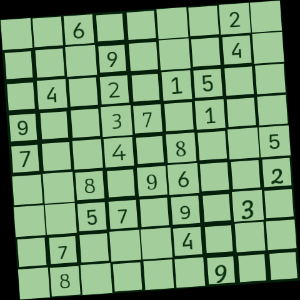

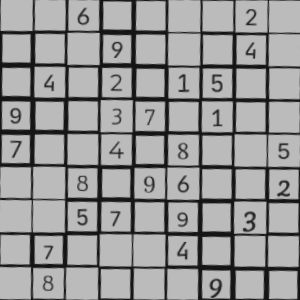

In [ ]:
impath=np.random.choice(imgs)
print(impath)
imid=os.path.basename(impath)[:-4]
print(imid)

solstr=solutions.loc[int(imid),'solution']

img=cv2.imread(impath)
cv2_imshow(img)

# convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imsz = gray.shape[0]


img=derotate(gray)

cv2_imshow(img)


In [ ]:
labeldict={0:'1',1:'2',2:'3',3:'4',4:'5',5:'6',6:'7',7:'8',8:'9',9:'.'}

tmpdir='imgs4solv/'
# this can take a bit (maybe 30s)
# All_Data is the home directory for the images, from which training and validation splits will be taken
if not os.path.exists(f'{home_dir}{tmpdir}'):
  os.mkdir(f'{home_dir}{tmpdir}')

# segment the image and write to file
for rowind in range(9):
    for colind in range(9):
      subimg=img[(rowind*int(imsz/9)):((rowind+1)*int(imsz/9)),
                 (colind*int(imsz/9)):((colind+1)*int(imsz/9))]
      # convert to PIL and write to file
      # NOTE: converting to PIL to match the generating script
      Image.fromarray(subimg).save(f'{home_dir}{tmpdir}{rowind}{colind}.png')

test_imgs=get_image_files(f'{home_dir}{tmpdir}')
# sorting alphabetically works due to the naming structure in the loop above
test_imgs.sort()

tst_dl=learn.dls.test_dl(test_imgs)
preds = learn.get_preds(dl=tst_dl,inner=True)[0];

### Attempt straightforward solution ###
curgrid=pd.Series(torch.argmax(preds,dim=1).numpy()).map(labeldict)
curgrid=''.join(curgrid)

try:
  solved=solve(curgrid)
  solved_grid=''.join(solved.values())

  print('Sudoku grid solved correctly: '+str(solved_grid==solstr))
  # return curgrid, solved_grid
except:
  print('Solving failed')
  



Sudoku grid solved correctly: True


In [ ]:
preds = learn.tta(dl=tst_dl)

epoch,train_loss,valid_loss,accuracy,time


AttributeError: ignored

In [ ]:
sudoku_display(curgrid)
sudoku_display(solstr)

. . . | . . 8 | . . .
. . 2 | . . . | 1 5 7
. . . | 7 1 . | . 6 .
---------------------
8 . . | . . 5 | . 3 .
2 7 . | 3 . 1 | . 4 9
. 3 . | 9 . . | . . 1
---------------------
. 6 . | . 5 3 | . . .
9 2 8 | . . . | 3 . .
. . . | 3 . . | . . .
 
7 1 6 | 5 2 8 | 4 9 3
4 8 2 | 6 3 9 | 1 5 7
3 5 9 | 7 1 4 | 2 6 8
---------------------
8 9 1 | 4 6 5 | 7 3 2
2 7 5 | 3 8 1 | 6 4 9
6 3 4 | 9 7 2 | 5 8 1
---------------------
1 6 7 | 8 5 3 | 9 2 4
9 2 8 | 1 4 6 | 3 7 5
5 4 3 | 2 9 7 | 8 1 6
 


In [ ]:
# curfname=test_imgs[-1]
curfname='/content/All_Data/imgs4solv/83.png'
print(curfname)
learn.predict(curfname)

/content/All_Data/imgs4solv/83.png


('3',
 tensor(2),
 tensor([6.2624e-05, 8.1759e-03, 9.9144e-01, 2.3893e-05, 1.5271e-04, 3.9480e-06, 2.7283e-05, 2.1099e-05, 8.2167e-05, 8.7729e-06]))

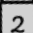

In [ ]:
cv2_imshow(cv2.imread(str(curfname)))

In [ ]:
  asd=preds.numpy().copy()

In [ ]:
asd.shape

(81, 10)

In [ ]:
for predrow in range(81):
  currow=asd[predrow,:]
  if np.sum(currow/np.max(currow)>1e-3)>=2:
    print(currow)

[9.98553455e-01 1.45246458e-05 1.13931565e-05 1.71128049e-04 4.84011025e-06 2.53580693e-05 1.13925477e-03 2.66665097e-06 1.34854258e-06 7.58871538e-05]
[6.2624429e-05 8.1758713e-03 9.9144155e-01 2.3892577e-05 1.5270954e-04 3.9480260e-06 2.7282691e-05 2.1099344e-05 8.2167440e-05 8.7728640e-06]


In [ ]:
predrow=75
currow=asd[predrow,:]

In [ ]:
np.any(currow/np.max(currow)>1e-3)

True

In [ ]:
currow[np.argmax(currow)]=0

In [ ]:
np.argmax(currow)

1